In [31]:
import pandas as pd
import json 
import numpy as np
from sklearn.cluster import OPTICS
#from scipy.spatial.distance import euclidean as d_euclidean
import warnings
import time
import threading
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import base64
from io import BytesIO

#* Optimizacion provisional y forma original

def d_euclidean(points1, points2):
    # Vectorized Euclidean distance
    return np.sqrt(np.sum((points1 - points2) ** 2, axis=-1))

def slope_to_rotation_matrix(slope):
    
    return np.array([[1, slope], [-slope, 1]])

def get_point_projection_on_line(point, line):

    line_slope = (line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if line[-1, 0] != line[0, 0] else np.inf

    if np.isinf(line_slope):
        return np.array([line[0,0], point[1]])
    
    R = slope_to_rotation_matrix(line_slope)

    rot_line = np.matmul(line, R.T)
    rot_point = np.matmul(point, R.T)

    proj = np.array([rot_point[0], rot_line[0,1]])

    R_inverse = np.linalg.inv(R)
    proj = np.matmul(proj, R_inverse.T)

    return proj

def get_point_projection_on_line_optimize(point, line):
    A = np.array(line[0])
    B = np.array(line[1])
    P = np.array(point)
    
    # Vectores AB y AP
    AB = B - A
    AP = P - A
    
    # Producto escalar de AB y AP, y producto escalar de AB con sí mismo
    dot_product = np.dot(AP, AB)
    AB_square = np.dot(AB, AB)
    
    # Factor de proyección sobre AB
    factor = dot_product / AB_square
    
    # Proyección en términos de vector
    projection = A + factor * AB
    
    return projection

def d_perpendicular(l1, l2):

    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    lehmer_1 = d_euclidean(l_shorter[0], ps)
    lehmer_2 = d_euclidean(l_shorter[-1], pe)

    if lehmer_1 == 0 and lehmer_2 == 0:
        return 0
    return (lehmer_1**2 + lehmer_2**2) / (lehmer_1 + lehmer_2)

def d_perpendicular_vectorized(vectors, line_lengths):
    n = len(vectors)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            l1, l2 = vectors[i], vectors[j]
            l1_len, l2_len = line_lengths[i], line_lengths[j]
            if l1_len < l2_len:
                l_shorter, l_longer = l1, l2
            else:
                l_shorter, l_longer = l2, l1

            ps = get_point_projection_on_line_optimize(l_shorter[0], l_longer)
            pe = get_point_projection_on_line_optimize(l_shorter[-1], l_longer)
            
            lehmer_1 = d_euclidean(l_shorter[0], ps)
            lehmer_2 = d_euclidean(l_shorter[-1], pe)

            if lehmer_1 == 0 and lehmer_2 == 0:
                dist_matrix[i, j] = 0
            else:
                dist_matrix[i, j] = (lehmer_1**2 + lehmer_2**2) / (lehmer_1 + lehmer_2)

            dist_matrix[j, i] = dist_matrix[i, j]

    return dist_matrix

def d_angular(l1, l2, directional=True):

    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    shorter_slope = (l_shorter[-1,1] - l_shorter[0,1]) / (l_shorter[-1,0] - l_shorter[0,0]) if l_shorter[-1,0] - l_shorter[0,0] != 0 else np.inf
    longer_slope = (l_longer[-1,1] - l_longer[0,1]) / (l_longer[-1,0] - l_longer[0,0]) if l_longer[-1,0] - l_longer[0,0] != 0 else np.inf

    theta = None
    if np.isinf(shorter_slope):
        tan_theta0 = longer_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    elif np.isinf(longer_slope):
        tan_theta0 = shorter_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    else:
        tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)
        tan_theta1 = tan_theta0 * -1

        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))

        theta = min(theta0, theta1)

    if directional:
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])

    if 0 <= theta < (90 * np.pi / 180):
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
    elif (90 * np.pi / 180) <= theta <= np.pi:
        return np.sin(theta)
    else:
        raise ValueError("Theta is not in the range of 0 to 180 degrees.")

def d_angular_vectorized(vectors, line_lengths,  directional=True):
    n = len(vectors)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            l1, l2 = vectors[i], vectors[j]
            l_shorter = l_longer = None
            l1_len, l2_len = line_lengths[i], line_lengths[j]
            if l1_len < l2_len:
                l_shorter, l_longer = l1, l2
            else:
                l_shorter, l_longer = l2, l1

            # Get the minimum intersecting angle between both lines
            shorter_slope = (l_shorter[-1,1] - l_shorter[0,1]) / (l_shorter[-1,0] - l_shorter[0,0]) if l_shorter[-1,0] - l_shorter[0,0] != 0 else np.inf
            longer_slope = (l_longer[-1,1] - l_longer[0,1]) / (l_longer[-1,0] - l_longer[0,0]) if l_longer[-1,0] - l_longer[0,0] != 0 else np.inf

            # The case of a vertical line
            theta = None
            if np.isinf(shorter_slope):
                # Get the angle of the longer line with the x-axis and subtract it from 90 degrees
                tan_theta0 = longer_slope
                tan_theta1 = tan_theta0 * -1
                theta0 = np.abs(np.arctan(tan_theta0))
                theta1 = np.abs(np.arctan(tan_theta1))
                theta = min(theta0, theta1)
            elif np.isinf(longer_slope):
                # Get the angle of the shorter line with the x-axis and subtract it from 90 degrees
                tan_theta0 = shorter_slope
                tan_theta1 = tan_theta0 * -1
                theta0 = np.abs(np.arctan(tan_theta0))
                theta1 = np.abs(np.arctan(tan_theta1))
                theta = min(theta0, theta1)
            else:
                tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)
                tan_theta1 = tan_theta0 * -1

                theta0 = np.abs(np.arctan(tan_theta0))
                theta1 = np.abs(np.arctan(tan_theta1))

                theta = min(theta0, theta1)

            if directional:
                dist_matrix[i, j] = np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
            else:
                if 0 <= theta < (90 * np.pi / 180):
                    dist_matrix[i, j] = np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
                elif (90 * np.pi / 180) <= theta <= np.pi:
                    dist_matrix[i, j] = np.sin(theta)
                else:
                    raise ValueError("Theta is not in the range of 0 to 180 degrees.")
            
            dist_matrix[j, i] = dist_matrix[i, j]
            
    return dist_matrix

def d_parallel_vectorized(vectors, line_lengths):
    n = len(vectors)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            l1, l2 = vectors[i], vectors[j]
            l_shorter = l_longer = None
            l1_len, l2_len = line_lengths[i], line_lengths[j]
            if l1_len < l2_len:
                l_shorter, l_longer = l1, l2
            else:
                l_shorter, l_longer = l2, l1

            ps = get_point_projection_on_line_optimize(l_shorter[0], l_longer)
            pe = get_point_projection_on_line_optimize(l_shorter[-1], l_longer)

            parallel_1 = min(d_euclidean(l_longer[0], ps), d_euclidean(l_longer[-1], ps))
            parallel_2 = min(d_euclidean(l_longer[0], pe), d_euclidean(l_longer[-1], pe))

            dist_matrix[i, j] = min(parallel_1, parallel_2)

            dist_matrix[j, i] = dist_matrix[i, j]
        
    return dist_matrix

def distance_vector_4(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):

    # Contenedores para los resultados
    results = {
        'perpendicular': None,
        'parallel': None,
        'angular': None
    }

    line_lengths = [d_euclidean(vec[0], vec[-1]) for vec in partitions]    

    # Definir las funciones que se ejecutarán en cada thread
    def run_perpendicular():
        inicio_p = time.time()
        results['perpendicular'] = w_perpendicular * d_perpendicular_vectorized(partitions, line_lengths)
        fin_p = time.time()
        print("Tiempo perpendicular: ", fin_p - inicio_p)

    def run_parallel():
        inicio_pa = time.time()
        results['parallel'] = w_parallel * d_parallel_vectorized(partitions, line_lengths)
        fin_pa = time.time()
        print("Tiempo paralelo: ", fin_pa - inicio_pa)

    def run_angular():
        inicio_a = time.time()
        results['angular'] = w_angular * d_angular_vectorized(partitions, line_lengths, directional)
        fin_a = time.time()
        print("Tiempo angular: ", fin_a - inicio_a)

    # Crear los threads
    thread_perpendicular = threading.Thread(target=run_perpendicular)
    thread_parallel = threading.Thread(target=run_parallel)
    thread_angular = threading.Thread(target=run_angular)

    # Iniciar los threads
    thread_perpendicular.start()
    thread_parallel.start()
    thread_angular.start()

    # Esperar a que todos los threads terminen
    thread_perpendicular.join()
    thread_parallel.join()
    thread_angular.join()

    # Sumar los resultados
    return results['perpendicular'] + results['parallel'] + results['angular']

def get_vectorice4_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    partitions = np.asarray(partitions)  # Asegurar que partitions sea un array de NumPy
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))
    
    dist_matrix = distance_vector_4(partitions, directional, w_perpendicular, w_parallel, w_angular)

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix

# Particiones

def partition2segments(partition):

    if not isinstance(partition, np.ndarray):
        raise TypeError("partition must be of type np.ndarray")
    elif partition.shape[1] != 2:
        raise ValueError("partition must be of shape (n, 2)")
    
    segments = []
    for i in range(partition.shape[0]-1):
        segments.append(np.array([[partition[i, 0], partition[i, 1]], [partition[i+1, 0], partition[i+1, 1]]]))

    return segments

def minimum_desription_length(start_idx, curr_idx, trajectory, w_angular=1, w_perpendicular=1, par=True, directional=True):
    
    LH = LDH = 0
    for i in range(start_idx, curr_idx-1):
        ed = d_euclidean(trajectory[i], trajectory[i+1])
        LH += max(0, np.log2(ed, where=ed>0))
        if par:
            for j in range(start_idx, i-1):
                LDH += w_perpendicular * d_perpendicular(np.array([trajectory[start_idx], trajectory[i]]), np.array([trajectory[j], trajectory[j+1]]))
                LDH += w_angular * d_angular(np.array([trajectory[start_idx], trajectory[i]]), np.array([trajectory[j], trajectory[j+1]]), directional=directional)
    if par:
        return LH + LDH
    return LH

def partition(trajectory, directional=True, progress_bar=False, w_perpendicular=1, w_angular=1):
    
    if not isinstance(trajectory, np.ndarray):
        raise TypeError("La trayectoria debe ser un arreglo de NumPy")
    elif trajectory.shape[1] != 2:
        raise ValueError("La trayectoria debe tener la forma (n, 2)")
    
    cp_indices = [0]

    traj_len = trajectory.shape[0]
    start_idx = 0  
    
    length = 1  
    while start_idx + length < traj_len: 
        if progress_bar:
            print(f'\r{round(((start_idx + length) / traj_len) * 100, 2)}%', end='')
        
        curr_idx = start_idx + length 

        cost_par = minimum_desription_length(start_idx, curr_idx, trajectory, w_angular=w_angular, w_perpendicular=w_perpendicular, directional=directional)
        cost_nopar = minimum_desription_length(start_idx, curr_idx, trajectory, par=False, directional=directional)

        if cost_par > cost_nopar: 
            cp_indices.append(curr_idx-1)  
            start_idx = curr_idx-1
            length = 1
        else:
            length += 1 

    cp_indices.append(len(trajectory) - 1)

    return np.array([trajectory[i] for i in cp_indices])

# Representacion de trayecorias

def get_average_direction_slope(line_list):

    slopes = []
    for line in line_list:
        slopes.append((line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if (line[-1, 0] - line[0, 0]) != 0 else 0)
    slopes = np.array(slopes)

    return np.mean(slopes)

def get_representative_trajectory(lines, min_lines=3):
    
    average_slope = get_average_direction_slope(lines)
    rotation_matrix = slope_to_rotation_matrix(average_slope)

    rotated_lines = []
    for line in lines:
        rotated_lines.append(np.matmul(line, rotation_matrix.T))

    starting_and_ending_points = []
    for line in rotated_lines:
        starting_and_ending_points.append(line[0])
        starting_and_ending_points.append(line[-1])
    starting_and_ending_points = np.array(starting_and_ending_points)

    starting_and_ending_points = starting_and_ending_points[starting_and_ending_points[:, 0].argsort()]

    representative_points = []
    for p in starting_and_ending_points:
        num_p = 0
        for line in rotated_lines:
            point_sorted_line = line[line[:, 0].argsort()]
            if point_sorted_line[0, 0] <= p[0] <= point_sorted_line[-1, 0]:
                num_p += 1

        if num_p >= min_lines:
            y_avg = 0
            for line in rotated_lines:
                point_sorted_line = line[line[:, 0].argsort()]
                if point_sorted_line[0, 0] <= p[0] <= point_sorted_line[-1, 0]:
                    y_avg += (point_sorted_line[0, 1] + point_sorted_line[-1, 1]) / 2
            y_avg /= num_p
            representative_points.append(np.array([p[0], y_avg]))

    if len(representative_points) == 0:
        warnings.warn("ADVERTENCIA: No se encontraron puntos representativos.")
        return np.array([])

    representative_points = np.array(representative_points)
    representative_points = np.matmul(representative_points, np.linalg.inv(rotation_matrix).T)

    return representative_points

# Traclus

def traclus(trajectories, max_eps=None, min_samples=5, directional=True, use_segments=True, clustering_algorithm=OPTICS, mdl_weights=[1,1,1], d_weights=[1,1,1], progress_bar=False):
    """
        Trajectory Clustering Algorithm
    """
    # Ensure that the trajectories are a list of numpy arrays of shape (n, 2)
    if not isinstance(trajectories, list):
        raise TypeError("Trajectories must be a list")
    for trajectory in trajectories:
        if not isinstance(trajectory, np.ndarray):
            raise TypeError("Trajectories must be a list of numpy arrays")
        elif len(trajectory.shape) != 2:
            raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")
        elif trajectory.shape[1] != 2:
            raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")

    # Partition trajectories
    if progress_bar:
        print("Partitioning trajectories...")
    partitions = []
    i = 0
    for trajectory in trajectories:
        if progress_bar:
            print(f"\rTrajectory {i + 1}/{len(trajectories)}", end='')
            i += 1
        partitions.append(partition(trajectory, directional=directional, progress_bar=False, w_perpendicular=mdl_weights[0], w_angular=mdl_weights[2]))
    if progress_bar:
        print()

    # Convert partitions to segments
    segments = []
    if use_segments:
        if progress_bar:
            print("Converting partitioned trajectories to segments...")
        i = 0
        for parts in partitions:
            if progress_bar:
                print(f"\rPartition {i + 1}/{len(parts)}", end='')
            segments += partition2segments(parts)
    else:
        segments = partitions

    # Get distance matrix
    dist_matrix = get_vectorice4_distance_matrix(segments)

    # Group the partitions
    if progress_bar:
        print("Grouping partitions...")
    clusters = []
    clustering_model = None
    if max_eps is not None:
        clustering_model = clustering_algorithm(max_eps=max_eps, min_samples=min_samples)
    else:
        clustering_model = clustering_algorithm(min_samples=min_samples)
    cluster_assignments = clustering_model.fit_predict(dist_matrix)
    for c in range(min(cluster_assignments), max(cluster_assignments) + 1):
        clusters.append([segments[i] for i in range(len(segments)) if cluster_assignments[i] == c])

    if progress_bar:
        print()

    # Get the representative trajectories
    if progress_bar:
        print("Getting representative trajectories...")
    representative_trajectories = []
    for cluster in clusters:
        representative_trajectories.append(get_representative_trajectory(cluster))
    if progress_bar:
        print()

    return partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories

In [56]:
#* Representación de resultados

def create_gdf(data):
    valid_geometries = [LineString(x) for x in data if len(x) > 1]
    gdf = gpd.GeoDataFrame(geometry=valid_geometries, crs='EPSG:4326')

    return gdf

def get_cluster_trajectories(trajectories, df):
    _, _, _, _, _, representative_trajectories = traclus(trajectories)

    # Representacion de las trayectorias pero sin el primer elemento, este parece ser solo un conjunto basura
    representative_clusters = representative_trajectories[1:representative_trajectories.__len__()]

    TRACLUS_map = plot_map_traclus(representative_clusters)
    TRACLUS_map_df = plot_map_traclus_df(representative_clusters, df)

    return TRACLUS_map, TRACLUS_map_df

def plot_map_traclus(representative_clusters, cmap='tab20'):
    # Crear un GeoDataFrame
    gdf = create_gdf(representative_clusters)

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)
    

    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())

    # Añadir título y etiquetas
    plt.title('Representación de Trayectorias TRACLUS')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')

    # Crear un objeto BytesIO para guardar la imagen
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)  # Mover el 'cursor' al principio del archivo en memoria
    # Es importante cerrar la figura para liberar memoria
    plt.close(fig)

    # Codificar la imagen generada en base64
    TRACLUS_map = base64.b64encode(img_data.read()).decode('utf-8')

    return TRACLUS_map

def plot_map_traclus_df(representative_clusters, df, cmap='tab20'):
    # Crear un GeoDataFrame
    gdf2 = create_gdf(df)
    gdf = create_gdf(representative_clusters)

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    gdf2.plot(ax=ax, color='blue', alpha=0.2, linewidth=0.5)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)
    

    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())

    # Añadir título y etiquetas
    plt.title('Representación de Trayectorias TRACLUS')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')

    # Crear un objeto BytesIO para guardar la imagen
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)  # Mover el 'cursor' al principio del archivo en memoria
    plt.show()
    # Es importante cerrar la figura para liberar memoria
    plt.close(fig)

    # Codificar la imagen generada en base64
    TRACLUS_map_df = base64.b64encode(img_data.read()).decode('utf-8')

    return TRACLUS_map_df


In [57]:
""" nrows = 100
# Ruta del archivo CSV
filename = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv"

def load_and_simplify_data(filename, rows, tolerance=0.001, umbral_distancia=0.01):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    
    # Filtrar y crear LineString para cada polilínea
    def create_line(x):
        points = json.loads(x)
        if len(points) > 1:
            return LineString(points)
        return None
    
    df['geometry'] = df['POLYLINE'].apply(create_line)
    
    # Eliminar filas con geometrías nulas
    df = df[df['geometry'].notnull()]
    
    # Convertir a Geopandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Simplificar las geometrías
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)

    # Convertir las polilíneas de JSON a listas de coordenadas
    df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)

    # Filtrar filas con polilíneas vacías o nulas
    df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

    # Preparar las trayectorias para TRACLUS
    trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]
    
    return gdf, trayectorias

gdf, trayectorias  = load_and_simplify_data(filename, nrows) """

' nrows = 100\n# Ruta del archivo CSV\nfilename = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv"\n\ndef load_and_simplify_data(filename, rows, tolerance=0.001, umbral_distancia=0.01):\n    # Cargar datos\n    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)\n    \n    # Filtrar y crear LineString para cada polilínea\n    def create_line(x):\n        points = json.loads(x)\n        if len(points) > 1:\n            return LineString(points)\n        return None\n    \n    df[\'geometry\'] = df[\'POLYLINE\'].apply(create_line)\n    \n    # Eliminar filas con geometrías nulas\n    df = df[df[\'geometry\'].notnull()]\n    \n    # Convertir a Geopandas DataFrame\n    gdf = gpd.GeoDataFrame(df, geometry=\'geometry\')\n    \n    # Simplificar las geometrías\n    gdf[\'geometry\'] = gdf[\'geometry\'].simplify(tolerance)\n\n    # Convertir las polilíneas de JSON a listas de coordenadas\n    df[\'POLYLINE\'] = df[\'POLYLINE\'].apply(l

In [58]:
nrows = 100
# Ruta del archivo CSV
filename = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv"

# Leer el archivo CSV
df = pd.read_csv(filename, nrows=nrows, sep=",", low_memory=False)

# Convertir las polilíneas de JSON a listas de coordenadas
df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)

# Filtrar filas con polilíneas vacías o nulas
df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

# Preparar las trayectorias para TRACLUS
trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

C:\Users\Álvaro\AppData\Local\Temp\ipykernel_21584\2762556748.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)


Tiempo angular:  10.456113338470459


C:\Users\Álvaro\AppData\Local\Temp\ipykernel_21584\2762556748.py:60: RuntimeWarning: invalid value encountered in scalar divide
  factor = dot_product / AB_square


Tiempo perpendicular:  58.613263845443726
Tiempo paralelo:  62.29630708694458


C:\Users\Álvaro\AppData\Local\Temp\ipykernel_21584\2762556748.py:303: UserWarning: La matriz de distancias contiene valores NaN
  warnings.warn("La matriz de distancias contiene valores NaN")
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_21584\2762556748.py:416: UserWarning: ADVERTENCIA: No se encontraron puntos representativos.
  warnings.warn("ADVERTENCIA: No se encontraron puntos representativos.")


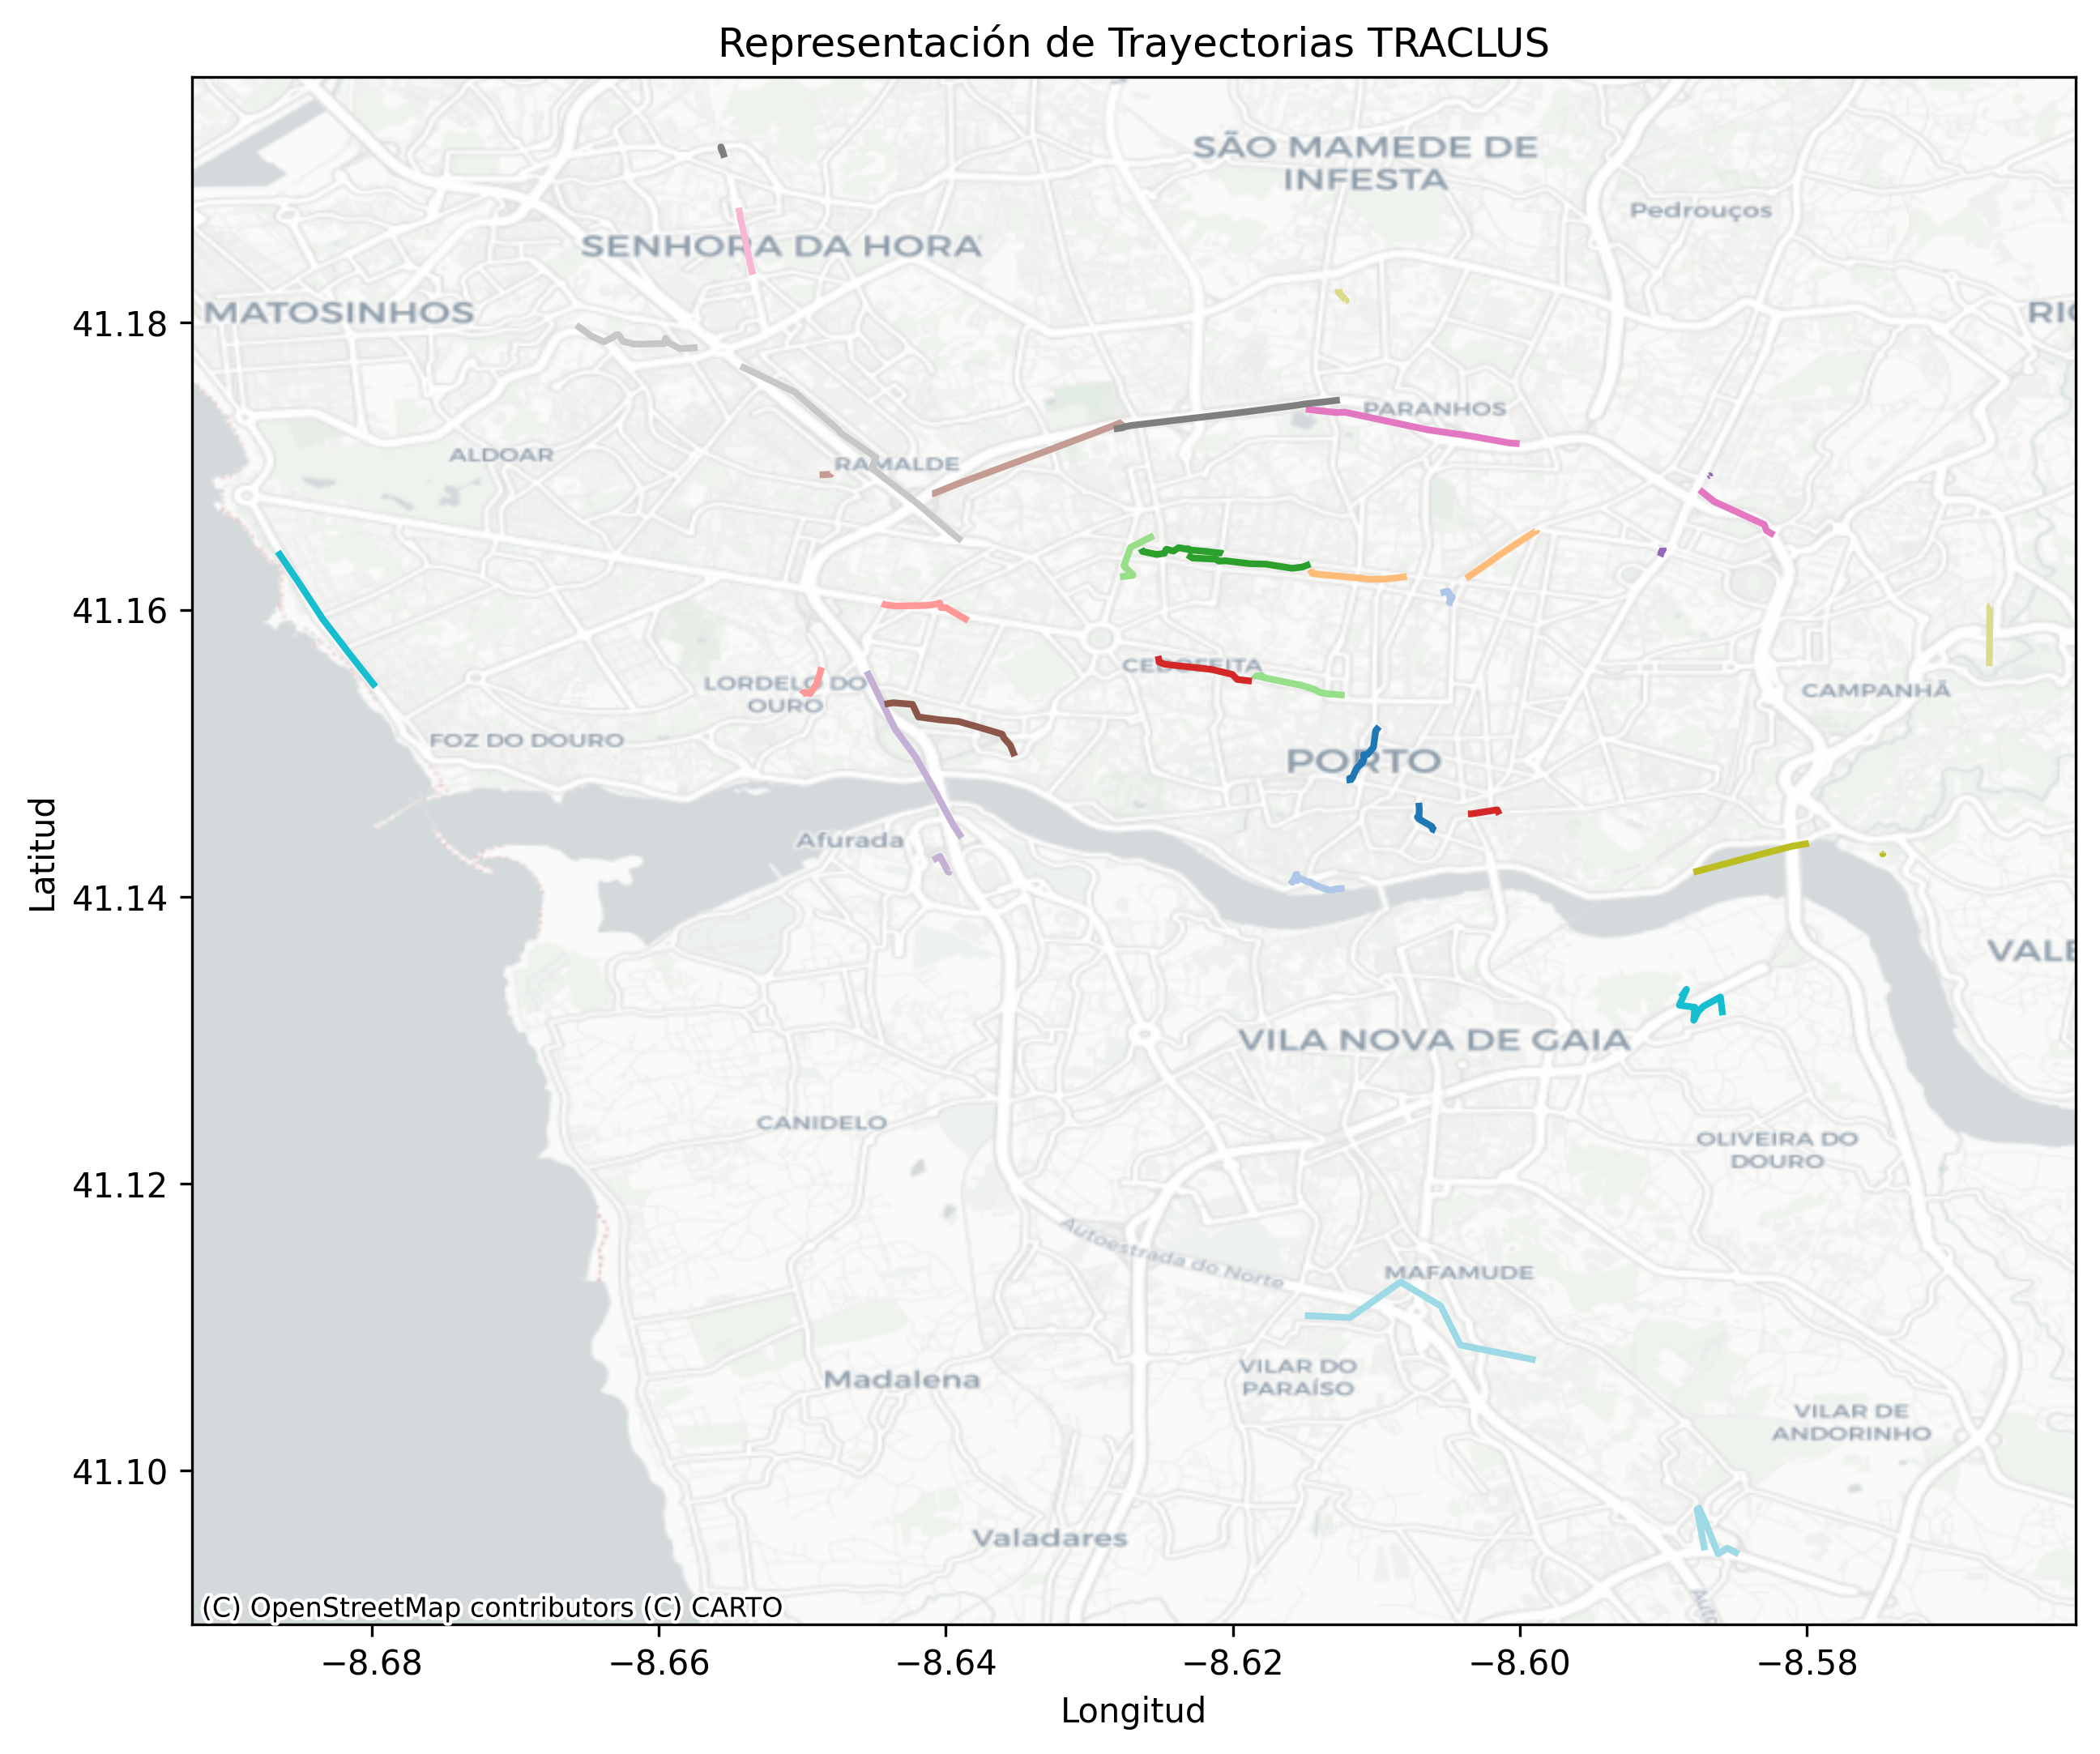

'iVBORw0KGgoAAAANSUhEUgAAC7gAAAu4CAYAAABxFfV5AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAC4jAAAuIwF4pT92AAEAAElEQVR4nOzdeZSU1Z34/08jO8i+CErADRUXVJaIIpvR4JDEgFvMqOBoZIxO4mTUHPJNxiU6Go3GLBPFGFHjNuNCIjEadUTiAoqyKS4RBBRENtlptu7n94cHflZXQ1d1N/TVvF7n9Dn27brPvV1d/Tylvqu6JMuyLAAAAAAAAAAAAAAAoI7Vq+sNAAAAAAAAAAAAAABAhMAdAAAAAAAAAAAAAIBECNwBAAAAAAAAAAAAAEiCwB0AAAAAAAAAAAAAgCQI3AEAAAAAAAAAAAAASILAHQAAAAAAAAAAAACAJAjcAQAAAAAAAAAAAABIgsAdAAAAAAAAAAAAAIAkCNwBAAAAAAAAAAAAAEiCwB0AAAAAAAAAAAAAgCQI3AEAAAAAAAAAAAAASILAHQAAAAAAAAAAAACAJAjcAQAAAAAAAAAAAABIgsAdAAAAAAAAAAAAAIAkCNwBAAAAAAAAAAAAAEiCwB0AAAAAAAAAAAAAgCQI3AEAAAAAAAAAAAAASILAHQAAAAAAAAAAAACAJAjcAQAAAAAAAAAAAABIgsAdAAAAAAAAAAAAAIAkCNwBAAAAAAAAAAAAAEiCwB0AAAAAAAAAAAAAgCQI3AEAAAAAAAAAAAAASILAHQAAAAAAAAAAAACAJAjcAQAAAAAAAAAAAABIgsAdAAAAAAAAAAAAAIAkCNwBAAAAAAAAAAAAAEiCwB0AAAAAAAAAAAAAgCQI3AEAAAAAAAAAAAAASILAHQAAAAAAAAAAAACAJAjcAQAAAAAAAAAAAABIgsAdAAAAAAAAAAAAAIAkCNwBAAAAAAAAAAAAAEiCwB0AAAAAAAA

In [59]:
get_cluster_trajectories(trayectorias, df['POLYLINE'])